# 2.0 Creating a Baseline Model

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import help_function as hf  # customized help functions

%matplotlib inline

df = pd.read_csv('data/ai4i2020.csv')

X = df.drop(columns='Machine failure')
y = df['Machine failure']

# train test split
# use stratify to enforce the proportion in the splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

## Create a baseline model

### 1. Build a Logistic Regression model using pipeline

In [18]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()
pipe = hf.create_pipe(clf)

In [19]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('proc_cols',
                 FunctionTransformer(func=<function col_name_cnvt at 0x000002D182954700>)),
                ('prep',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002D184DC26D0>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002D184DC2190>)])),
                ('model', LogisticRegression())])

### 2. Evaluate the model performance

#### Use hard decision

In [20]:
y_pred = pipe.predict(X_test)

{'recall': 0.25, 'precision': 0.6071428571428571, 'f1': 0.3541666666666667}

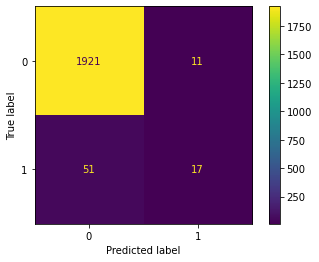

In [21]:
hf.evaluate(y_test, y_pred)

- Hard decision does not do a good job, the recall is very low.

#### Use soft decision

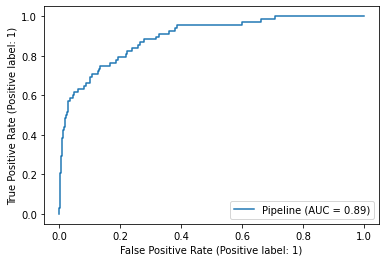

In [22]:
# Search for the best cutoff threshold
# It seems the 0.1 is a good choice
hf.RocCurveDisplay.from_estimator(pipe, X_test, y_test);

{'recall': 0.6029411764705882,
 'precision': 0.3203125,
 'f1': 0.4183673469387755}

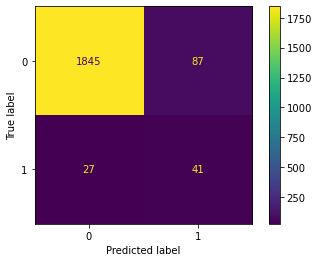

In [28]:
# Seems reasonable to set the cutoff point at 0.13
# and calculate the lables
y_hats = hf.soft_to_hard(pipe, X_test, cutoff=0.13)
hf.evaluate(y_test, y_hats)

Given the recall a more important metrics, we choise the cutoff of 0.13. The bare-bone Logistic Regression achieves Recall of **~60%**, and the precision of **~32%**. 

### Cross validation

In [29]:
hf.k_fold(pipe, X_train, y_train, k=30, cutoff=0.13)

{'Mean Recall': 0.5888187901423196,
 'Mean Precision': 0.3286576343619687,
 'Mean F1': 0.4147113683209028}

- The soft decision with cross validation shows a similar result.

### Hyperparameter Tuning

In [31]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__penalty': ['elasticnet'],
    'model__max_iter': [400, 500, 600],
    'model__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4],
    'model__solver': ['saga']
}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=40, scoring='recall', refit=True)

grid.fit(X_train, y_train)

GridSearchCV(cv=40,
             estimator=Pipeline(steps=[('proc_cols',
                                        FunctionTransformer(func=<function col_name_cnvt at 0x000002D182954700>)),
                                       ('prep',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002D184DC26D0>),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x000002D184DC2190>)])),
                                       ('model', LogisticRegression())]),

In [32]:
grid.best_params_

{'model__l1_ratio': 0,
 'model__max_iter': 400,
 'model__penalty': 'elasticnet',
 'model__solver': 'saga'}

{'recall': 0.6029411764705882,
 'precision': 0.3203125,
 'f1': 0.4183673469387755}

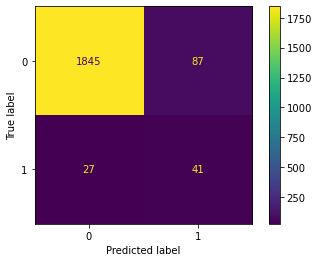

In [33]:
y_hats = hf.soft_to_hard(grid, X_test, cutoff=0.13)
hf.evaluate(y_test, y_hats)

- Even with the best parameters, the model performance does not improve much. 